# Train Loop （built-in method）

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
# 数据合成
# The actual line
TRUE_W = 3.0
TRUE_B = 2.0

NUM_EXAMPLES = 201

# A vector of random x values
x = tf.linspace(-2,2, NUM_EXAMPLES)
x = tf.cast(x, tf.float32)

def f(x):
  return x * TRUE_W + TRUE_B

# Generate some noise
noise = tf.random.normal(shape=[NUM_EXAMPLES])

# Calculate y
y = f(x) + noise

2022-02-15 16:33:10.310833: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-15 16:33:10.333454: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fef3e683750 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-02-15 16:33:10.333468: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [3]:
# 前向过程
class MyModel(tf.Module):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    # Initialize the weights to `5.0` and the bias to `0.0`
    # In practice, these should be randomly initialized
    self.w = tf.Variable(5.0)
    self.b = tf.Variable(0.0)

  def __call__(self, x):
    return self.w * x + self.b

model = MyModel()

# List the variables tf.modules's built-in variable aggregation.
print("Variables:", model.variables)

Variables: (<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=5.0>)


2022-02-15 16:33:55.760202: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [4]:
# Verify the model works
assert model(3.0).numpy() == 15.0

In [5]:
# 损失函数
# This computes a single loss value for an entire batch
def loss(target_y, predicted_y):
  return tf.reduce_mean(tf.square(target_y - predicted_y))

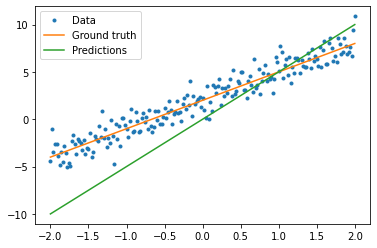

In [9]:
# 展示数据
plt.plot(x, y, '.', label="Data")
plt.plot(x, f(x), label="Ground truth")
plt.plot(x, model(x), label="Predictions")
plt.legend()
plt.show()

In [10]:
# 初始损失
print("current loss: %1.6f" % loss(y, model(x)))

current loss: 10.586820


训练的过程：  
持续做：  
1. 输入批次，产生输出
2. 对比输出和真实标签，产生损失loss
3. 找到变量的梯度
4. 更新变量

步骤1和2用gradientTape记录，步骤3用gradTape.gradient()方法来求得，步骤4用tf.Variables.assign_sub()方法来更新参数

In [11]:
def train(model, x, y, learning_rate):
    with tf.GradientTape() as t:
        # 可训练变量自动被gradientTape记录
        current_loss = loss(y, model(x))
    # 求梯度
    dw, db = t.gradient(current_loss, [model.w, model.b])
    # 更新参数
    model.w.assign_sub(learning_rate * dw)
    model.b.assign_sub(learning_rate * db)

In [18]:
model = MyModel()
# Collect the history of W-values and b-values to plot later
weights = []
biases = []
epochs = 10

In [14]:
# Define a training loop
def report(model, current_loss):
    return f"W = {model.w.numpy():1.2f}, b = {model.b.numpy():1.2f}, loss={current_loss:2.5f}"

In [19]:
def training_loop(model, x, y):
    for epoch in range(epochs):
        # 用所有样本来更新模型
        train(model, x, y, learning_rate=0.1)
        # 记录参数
        weights.append(model.w.numpy())
        biases.append(model.b.numpy())
        current_loss = loss(y, model(x))

        print(f"Epoch {epoch:2d}")
        print("     ", report(model, current_loss))

In [20]:
init_loss = loss(y, model(x))
print(f"Starting:")
print("    ", report(model, init_loss))

Starting:
     W = 5.00, b = 0.00, loss=10.58682


In [21]:
training_loop(model, x, y)

Epoch  0
      W = 4.47, b = 0.41, loss=6.61028
Epoch  1
      W = 4.08, b = 0.75, loss=4.32352
Epoch  2
      W = 3.80, b = 1.01, loss=2.99785
Epoch  3
      W = 3.59, b = 1.22, loss=2.22302
Epoch  4
      W = 3.44, b = 1.39, loss=1.76642
Epoch  5
      W = 3.33, b = 1.53, loss=1.49518
Epoch  6
      W = 3.25, b = 1.64, loss=1.33278
Epoch  7
      W = 3.19, b = 1.72, loss=1.23482
Epoch  8
      W = 3.15, b = 1.79, loss=1.17532
Epoch  9
      W = 3.12, b = 1.85, loss=1.13895


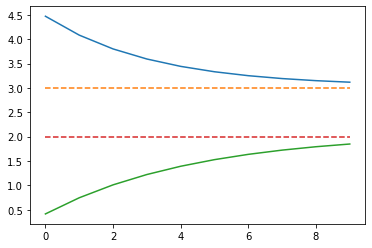

In [22]:
plt.plot(range(epochs), weights)
plt.plot(range(epochs), [TRUE_W]*epochs, "--")
plt.plot(range(epochs), biases)
plt.plot(range(epochs), [TRUE_B]*epochs, "--")
plt.show()

# Train Loop (keras method)

使用keras对象定义好模型之后，可以使用tf.Module类似的方法（即gradientTape等）来更新模型  

In [23]:
# 使用keras接口来定义model
class MyModelKeras(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = tf.Variable(5.0)
        self.b = tf.Variable(0.0)

    def call(self, x):
        return self.w * x + self.b

keras_model = MyModelKeras()

# Reuse the training loop with a Keras model
training_loop(keras_model, x, y)

# You can also save a checkpoint using Keras's built-in support
keras_model.save_weights("../../model/my_linear_keras_checkpoint")

Epoch  0
      W = 4.47, b = 0.41, loss=6.61028
Epoch  1
      W = 4.08, b = 0.75, loss=4.32352
Epoch  2
      W = 3.80, b = 1.01, loss=2.99785
Epoch  3
      W = 3.59, b = 1.22, loss=2.22302
Epoch  4
      W = 3.44, b = 1.39, loss=1.76642
Epoch  5
      W = 3.33, b = 1.53, loss=1.49518
Epoch  6
      W = 3.25, b = 1.64, loss=1.33278
Epoch  7
      W = 3.19, b = 1.72, loss=1.23482
Epoch  8
      W = 3.15, b = 1.79, loss=1.17532
Epoch  9
      W = 3.12, b = 1.85, loss=1.13895


keras model也可以使用.compile()方法来设定参数，比如优化器和loss函数；并使用.fit()方法来训练

In [24]:
keras_model = MyModelKeras()
# .compile()方法

keras_model.compile(
    # By default, fit() uses tf.function().  You can
    # turn that off for debugging, but it is on now.
    run_eagerly=False,

    # Using a built-in optimizer, configuring as an object
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),

    # Keras comes with built-in MSE error
    # However, you could use the loss function
    # defined above
    loss=tf.keras.losses.mean_squared_error,
)

In [ ]:
# .fit()方法接受批次数据；也可接受完整数据（numpy array），并根据batch_size参数来切割

In [27]:
print(x.shape[0])
keras_model.fit(x, y, epochs=10, batch_size=1000)

201
Epoch 1/10
1/1 [==============================] - 0s 2ms/step - loss: 10.5868
Epoch 2/10
1/1 [==============================] - 0s 632us/step - loss: 6.6103
Epoch 3/10
1/1 [==============================] - 0s 708us/step - loss: 4.3235
Epoch 4/10
1/1 [==============================] - 0s 753us/step - loss: 2.9979
Epoch 5/10
1/1 [==============================] - 0s 1ms/step - loss: 2.2230
Epoch 6/10
1/1 [==============================] - 0s 693us/step - loss: 1.7664
Epoch 7/10
1/1 [==============================] - 0s 584us/step - loss: 1.4952
Epoch 8/10
1/1 [==============================] - 0s 671us/step - loss: 1.3328
Epoch 9/10
1/1 [==============================] - 0s 561us/step - loss: 1.2348
Epoch 10/10
1/1 [==============================] - 0s 851us/step - loss: 1.1753
